In [1]:
%matplotlib notebook

import numpy as np
from matplotlib import pyplot as plt
from scipy import pi
from sympy.physics.wigner import clebsch_gordan,wigner_3j,wigner_6j
from sympy import N
from arc import Cesium
tau=2*pi

In [2]:
from basics import *
from rabi_frequencies import *
from atomic_physics import *
from hybrid_matrix_elements import *

# Relevant computed constants

## q_rad_int
The result of the radial integral
$$\int_0^{\infty} r^4 R_{6,0}(r) R_{5, 2}(r) $$
Where $R_{n, l}(r)$ is the radial wavefunction for the valence electron in neutral Cesium when it's principle quantum number, and orbital angular momentum quantum number are $n$ and $l$ respectively

This is a numerically computed value available on the wiki. In SI units ($m^2$)

## d_rme_fs
The dipole reduced matrix element between our excited and rydberg states.
$$<5D5/2|| \textbf{e r} ||nP3/2>$$

Numerically computed value available on the wiki. In SI units ($Cm$)

## hf_A and hf_B
A and B hyperfine constants for the $|5D5/2>$ Fine structure level in cesium. From Havey1998. Available on the wiki. 

## DHF
list of hyperfine detunings for the 6D5/2 level, relative to the $fp=6$ HF manifold.
indexed by hyperfine qunatum number $fp$. ie the detuning of the $fp = 4$ level is **DHF\[4\]**

# gamma_e
linewidth of the 5D5/2 state.

In [18]:
print(f"q_rad_int = {q_rad_int/ao**2}a0^2")
print(f"d_rme_fs = {d_rme_fs(52)/ao/e}e a0")
print(f"5D5/2 HF splittings: \n\t" + "\n\t".join([f"f'={fp}': \Delta = 2\pi \\times {DHF[fp]/2/pi*1e-6:.0f} MHz" for fp in range(int(5/2+7/2)+1)]))
print(f"\gamma_e = {gamma_e*1e-3:.0f}kHz")

q_rad_int = 37.5a0^2
d_rme_fs = 0.006400386879521872e a0
5D5/2 HF splittings: 
	f'=0': \Delta = 2\pi \times 0+0j MHz
	f'=1': \Delta = 2\pi \times 425 MHz
	f'=2': \Delta = 2\pi \times 382 MHz
	f'=3': \Delta = 2\pi \times 319 MHz
	f'=4': \Delta = 2\pi \times 234 MHz
	f'=5': \Delta = 2\pi \times 127 MHz
	f'=6': \Delta = 2\pi \times 0 MHz
\gamma_e = 125kHz


# Rabi Frequency Functions
Here we use the functions from **rabi_frequencies** to create functions that are more specific to our experiment

In [5]:
def q_rme_h(q_rad: float) -> complex:
    """
    Computes reduced matrix element for the quadrupole transition between the |6S> -> |5D> states, given the value of the
    radial integral between those levels.
    
    The reduced matrix element is <5D||C_2/sqrt(15)||6S>.
    Args:
        q_rad : numerical value of the radial integral between the ground and excited states. Expected to be in SI units (m**2)
    Returns:
        q_rme : the reduced matrix element for the quadrupole transition in the nl basis. In SI units (Cm**2)
    """
    q_radial_intergal = 37.5*ao**2
    # Quadrupole excitation reduced matrix element in orbital angular momentum basis
    return e*clebsch_gordan(0,2,2,0,0,0)*q_radial_intergal/np.sqrt(15)
    
def q_rme_fs_h(q_rad: float) -> complex:
    """
    Computes reduced matrix element for the quadrupole transition between the |6S1/2> -> |5D5/2> states, given the value of the
    radial integral between those levels.
    
    The reduced matrix element is <5D5/2||C_2/sqrt(15)||6S1/2>.
    Args:
        q_rad : numerical value of the radial integral between the ground and excited states. Expected to be in SI units (m**2)
    Returns:
        q_rme : the reduced matrix element for the quadrupole transition in the fine structure basis. In SI units (Cm**2)
    """
    return quadrupole_rme_fs(
        q_rme_h(q_rad),
        0,
        1/2,
        2,
        5/2,
        1/2
    )

def q_rme_hf_h(q_rad: float, fp: moment) -> complex:
    """
    Computes reduced matrix element for the quadrupole transition between the |6S> -> |5D> states, given the value of the
    radial integral between those levels.
    
    The reduced matrix element is <5D5/2;fp||C_2/sqrt(15)||6S1/2;f=4>.
    Args:
        q_rad : numerical value of the radial integral between the ground and excited states. Expected to be in SI units (m**2)
        fp: hyperfine structure angular momentum quantum number for excited state. Should be integer or half integer
    Returns:
        q_rme : the reduced matrix element for the quadrupole transition in the hyperfine structure basis. In SI units (Cm**2)
    """
    return quadrupole_rme_hf(
        q_rme_fs_h(q_rad),
        1/2,
        4,
        5/2,
        fp,
        7/2
    )

def q_rabi_frequency(
    power: float,
    width: float,
    pol_ar: SphericalVector,
    k_ar: SphericalVector,
    q_rad: complex,
    fp: moment,
    mp: moment,
    phi: float = 0.0
) -> complex:
    """
    Computes the Rabi frequency between the Cesium states |6S1/2;f=4,m=0> and |5D5/2;fp,mp> through the quadrupole transition
    at 684nm given parameters about the field, and the value of the radial integral between the two electron wavefunctions.
    
    Args:
        power: power of the laser field driving the rabi oscillation. (W)
        width: witdth of the laser field mode driving the rabi oscillation. (m)
        pol_ar: SphericalVector object describing the polarization of the field driving the rabi oscillation.
        k_ar: SphericalVector object describing the direction of the k-vector of the field driving the rabi oscillation.
        q_rad: value of the radial integral between the ground and excited state. (m**2)
        fp: hyperfine angular momentum quantum number of the excited state. Should be integer or half-integer
        mp: aziumthal angular momentum quantum number of the excited state. Should be integer or half-integer
        phi: phase of the electric field in radians. Default is 0.
    Returns:
        Rabi frequency coupling the ground state to the given excited state. (Hz)
    """
    e_field = electric_field_strength(power, width) * np.exp(1j*phi)
    rme = q_rme_hf_h(q_rad, fp)
    return quadrupole_rabi_frequency(
        e_field,
        freq(684e-9),
        pol_ar,
        k_ar,
        rme,
        4,
        0,
        fp,
        mp
    )

def d_rabi_frequency(
    power: float,
    width: float,
    pol_ar: SphericalVector,
    nr: int,
    fp: moment,
    mp: moment,
    mr: moment,
    phi: float = 0.0
) -> complex:
    """
    Computes the rabi frequency between the Cesium states |5D5/2;fp,mp> and |nrP3/2mr;7/2> where the
    lower state (primed state) is defined in the hyperfine basis, and the uppper state (rydberg state)
    is defined in the fine structure basis
    
    Args:
        power: power of the laser field driving the rabi oscillation. (W)
        width: witdth of the laser field mode driving the rabi oscillation. (m)
        pol_ar: SphericalVector object describing the polarization of the field driving the rabi oscillation.
        nr: principle quantum number of our target rydberg state
        fp: hyperfine angular momentum quantum number of our primed state
        mp: azimuthal angular momentum quantum number of our primed state
        mr: azimuthal angular momentum quantum number of our rydberg state
        phi: phase of the electric field in radians. Default is 0.
    Returns:
        Rabi frequency coupling the given excited state to the given rydberg state. (Hz)
    """
    e_field = electric_field_strength(power, width) * np.exp(1j*phi)
    rme = d_rme_fs(nr)
    return dipole_hf_to_fs(
        e_field,
        pol_ar,
        rme,
        5/2,
        fp,
        mp,
        3/2,
        mr,
        7/2
    )


# First Order Zeeman Corrections
This assumes a perfectly polarized $\textbf{B} = B\textbf{e}_z$

In [6]:
def zeeman_g(B: float) -> float:
    """
    Computes the lowest order correction to the |6S1/2;4,0> state using the second order correction to
    the energy level
    
    Args:
        B : Magnetic field strength. Assumed to be along the Z-direction (T)
    
    Returns:
        shift : The energy shift in the |6S1/2;4,0> state. Converted to angular frequency (Hz)
    """
    # The matrix element between the clock states <4,0|H_B|3,0> (Hz)
    me_4_3 = N(zeeman_me_hf(B, SphericalVector([1,0,0]), 0, 1/2, 4, 0, 1/2, 3, 0)/hb)
    return abs(me_4_3)**2/cs_clock

def zeeman_e(B: float, fe: moment, me: moment):
    """
    Computes the 1st order zeeman shift on the state |5D5/2;fe,me> using the zeeman_1o_hf() function.
    
    Args:
        B : Magnetic Field strength. Assumed to be along the quantization axis (T)
        fe : hyperfine angular momentum quantum number. Should be int or half-int
        me : azimuthal angular momentum quantum number. Should be int or half-int
        
    Returns:
        shift : The energy shift in the |5D5/2;fe,me> state. Converted to angular frequency (Hz)
    """
    return N(zeeman_1o_hf(B, 2, 5/2, fe, me)/hb)

def zeeman_R(B: float, nr: int, mr: moment):
    """
    Computes the 1st order zeeman shift on the state |nrP3/2,mr> using the zeeman_1o_fs() and the 
    diamagnetic_1o() functions on the state.
    
    Args:
        B: Magnetic Field strength. Assumed to be along the quantization axis (T)
        nr: principle quantum number of the Rydberg state
        mr: azimuthal quantum number of the Rydberg state. Should be int or half-int
        
    Returns:
        shift : The energy shift in the |nrP3/2,mr> state. Converted to angular frequency (Hz)
    """
    return N((zeeman_1o_fs(B, 1, 3/2, mr) + diamagnetic_1o_fs(B, nr, 1, 3/2, mr))/hb)
    

# Experiment parameters

In [10]:
p_ge = 100-3  # W
p_er = 35e-3  # W
w_ge = 14e-6  # m
w_er = 5e-6  # m
pol_ge = SphericalVector([0,0,1], spherical_basis=False)  # Z polarized
pol_er = SphericalVector([1,0,0])  # Z polarized
k_ar = SphericalVector([1,0,0], spherical_basis=False)  # X polarized
nr = 52  # Target Rydberg State
phi_ge = 0  # phase on 684nm field
phi_er = 0  # phase of 595nm field

bias_B = 5 * gauss # bias field in the z-direction

# Possible laser detunings from unperturbed intermediate states
detuning = np.linspace(min(DHF[1:]) - 2*pi*200e6, 0, 1000)
#detuning = np.linspace(2*pi*1e7, 2*pi*1e8, 1000)
delta = np.array([detuning - DET for DET in DHF])
swept_param = p_er

## Swept Frequency

In [11]:
O_ge = np.zeros((7,15), dtype=complex)  # ground-to-excited rabi frequencies
O_er = np.zeros((7,15,4), dtype=complex)  # excited-to-rydberg rabi frequencies

z_g = zeeman_g(bias_B)
z_e = np.zeros((7,15), dtype=float)  # zeeman shift on each of the states in the excited manifold
z_r = np.zeros(4, dtype=float)  # zeeman shift on each of the states in the Rydberg manifold

for fp in range(1,7):
    for mp in range(-fp, fp+1):
        O_ge[fp,mp] = q_rabi_frequency(p_ge, w_ge, pol_ge, k_ar, q_rad_int, fp, mp, phi = phi_ge)
        z_e[fp,mp] = zeeman_e(bias_B, fp, mp)
        for i, mr in enumerate(np.arange(-3/2,3/2+1,1)):
            O_er[fp,mp,i] = d_rabi_frequency(p_er, w_er, pol_er, nr, fp, mp, mr, phi = phi_er)
            z_r[i] = zeeman_R(bias_B, nr, mr)


In [25]:
rabi = np.zeros((4, len(detuning)), dtype = complex)
AC_stark = np.zeros((4, len(detuning)), dtype = complex)
p_scatter = np.zeros((4, len(detuning)), dtype = complex)

for i, mr in enumerate(np.arange(-3/2,3/2+1,1)):
    for fp in range(1,7):
        for mp in range(-fp, fp+1):
            d = delta[fp]-z_e[fp,mp]
            if fp == 6:
                print(f"g to |{fp},{mp}> to |{mr}>")
                print(f"\t{d[0]*1e-6/tau} - {d[-1]*1e-6/tau} Mhz")
                print(f"\tOmega_ge({fp},{mp}) = {O_ge[fp,mp]*1e-6/tau:.2f} MHz")
                print(f"\tOmega_er({fp},{mp}|mr={mr}) = {O_er[fp,mp,i]*1e-6/tau:.2f} MHz")
                con = (O_ge[fp,mp]*O_er[fp,mp,i])/(2)
                print(f"\tRabi Contribution = {con*1e-12/tau} MHz^2")
            rabi[i] += (O_ge[fp,mp]*O_er[fp,mp,i])/(2 * d)
            AC_stark[i] += (O_ge[fp,mp]*O_ge[fp,mp].conjugate() - O_er[fp,mp,i]*O_er[fp,mp,i].conjugate())/(4 * d)
            p_scatter[i] += gamma_e * (O_ge[fp,mp]*O_ge[fp,mp].conjugate() + O_er[fp,mp,i]*O_er[fp,mp,i].conjugate())/(2 * d)**2
    t_pi = pi/np.absolute(rabi[i])
    p_scatter[i] *= t_pi

g to |6,-6> to |-1.5>
	(-179.00734415245248+0j) - (20.99265584754748+0j) Mhz
	Omega_ge(6,-6) = 0.00+0.00j MHz
	Omega_er(6,-6|mr=-1.5) = 0.00+0.00j MHz
	Rabi Contribution = 0j MHz^2
g to |6,-5> to |-1.5>
	(-182.50612012704374+0j) - (17.493879872956228+0j) Mhz
	Omega_ge(6,-5) = 0.00+0.00j MHz
	Omega_er(6,-5|mr=-1.5) = 11.19+0.00j MHz
	Rabi Contribution = 0j MHz^2
g to |6,-4> to |-1.5>
	(-186.00489610163498+0j) - (13.995103898364984+0j) Mhz
	Omega_ge(6,-4) = 0.00+0.00j MHz
	Omega_er(6,-4|mr=-1.5) = 12.62+0.00j MHz
	Rabi Contribution = 0j MHz^2
g to |6,-3> to |-1.5>
	(-189.50367207622625+0j) - (10.49632792377374+0j) Mhz
	Omega_ge(6,-3) = 0.00+0.00j MHz
	Omega_er(6,-3|mr=-1.5) = 11.97+0.00j MHz
	Rabi Contribution = 0j MHz^2
g to |6,-2> to |-1.5>
	(-193.00244805081752+0j) - (6.997551949182492+0j) Mhz
	Omega_ge(6,-2) = 0.00+0.00j MHz
	Omega_er(6,-2|mr=-1.5) = 10.30+0.00j MHz
	Rabi Contribution = 0j MHz^2
g to |6,-1> to |-1.5>
	(-196.50122402540873+0j) - (3.498775974591246+0j) Mhz
	Omega_ge(6,

<ipython-input-25-0d8f423caf67>:16: RuntimeWarning: invalid value encountered in true_divide
  rabi[i] += (O_ge[fp,mp]*O_er[fp,mp,i])/(2 * d)
<ipython-input-25-0d8f423caf67>:17: RuntimeWarning: divide by zero encountered in true_divide
  AC_stark[i] += (O_ge[fp,mp]*O_ge[fp,mp].conjugate() - O_er[fp,mp,i]*O_er[fp,mp,i].conjugate())/(4 * d)
<ipython-input-25-0d8f423caf67>:17: RuntimeWarning: invalid value encountered in true_divide
  AC_stark[i] += (O_ge[fp,mp]*O_ge[fp,mp].conjugate() - O_er[fp,mp,i]*O_er[fp,mp,i].conjugate())/(4 * d)
<ipython-input-25-0d8f423caf67>:18: RuntimeWarning: divide by zero encountered in true_divide
  p_scatter[i] += gamma_e * (O_ge[fp,mp]*O_ge[fp,mp].conjugate() + O_er[fp,mp,i]*O_er[fp,mp,i].conjugate())/(2 * d)**2
<ipython-input-25-0d8f423caf67>:18: RuntimeWarning: invalid value encountered in true_divide
  p_scatter[i] += gamma_e * (O_ge[fp,mp]*O_ge[fp,mp].conjugate() + O_er[fp,mp,i]*O_er[fp,mp,i].conjugate())/(2 * d)**2
<ipython-input-25-0d8f423caf67>:20: 

In [26]:
9982/80

124.775

<IPython.core.display.Javascript object>


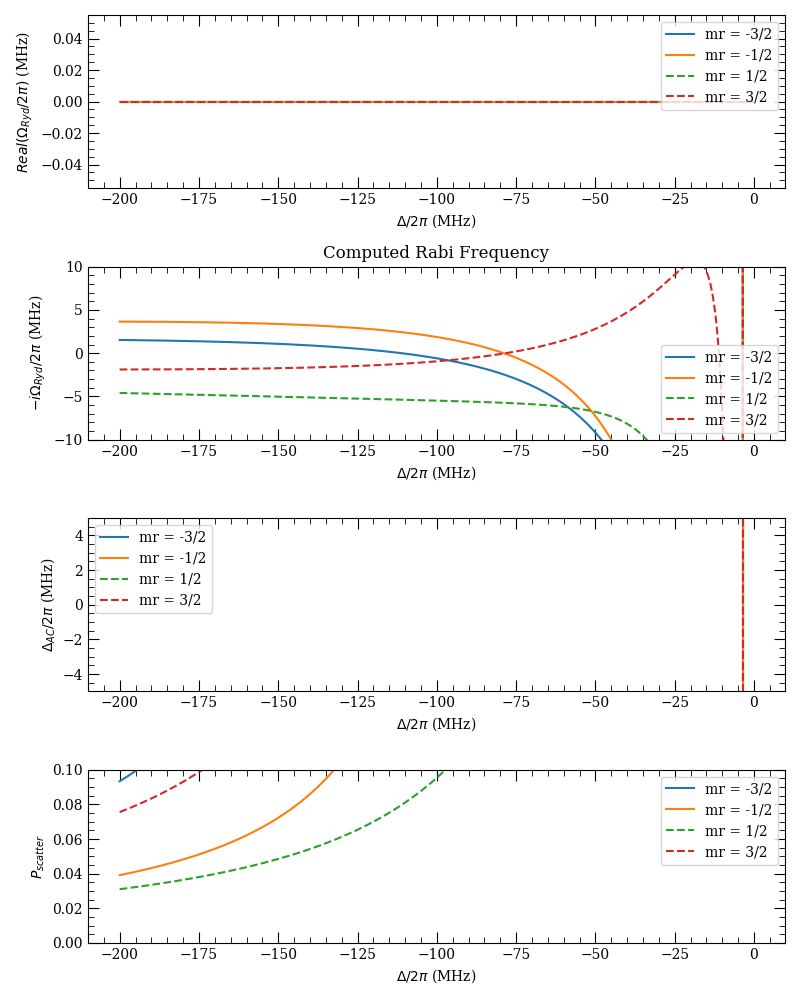

In [13]:
fig, axar = plt.subplots(4,1,figsize = (8,10))
ln = ['-','-','--','--']
for i, mr in enumerate(np.arange(-3/2,3/2+1)):
    plt_det = detuning * 1e-6 / (2 * pi)
    #rabi_r = rabi.real
    axar[0].plot(plt_det, rabi[i,:].real*1e-6/(2*pi), label = f"mr = {mr*2:.0f}/2",linestyle=ln[i])
    #axar[0].set_ylim(-10,10)
    axar[0].set_ylabel("$Real(\Omega_{Ryd}/2\pi)$ (MHz)")
    axar[0].set_xlabel("$\Delta/2\pi$ (MHz)")
    axar[0].legend()
    
    axar[1].plot(plt_det, rabi[i,:].imag*1e-6/(2*pi), label = f"mr = {mr*2:.0f}/2",linestyle=ln[i])
    axar[1].set_ylim(-10,10)
    axar[1].set_ylabel("$-i\Omega_{Ryd}/2\pi$ (MHz)")
    axar[1].set_xlabel("$\Delta/2\pi$ (MHz)")
    axar[1].set_title("Computed Rabi Frequency")
    #axar[1].axvline(80,ls=":",c="k")
    axar[1].legend()
    
    axar[2].plot(plt_det, AC_stark[i,:].real*1e-6/(2*pi), label = f"mr = {mr*2:.0f}/2",linestyle=ln[i])
    axar[2].set_ylim(-5,5)
    axar[2].set_ylabel("$\Delta_{AC}/2\pi$ (MHz)")
    axar[2].set_xlabel("$\Delta/2\pi$ (MHz)")
    axar[2].legend()
    
    axar[3].plot(plt_det, abs(p_scatter[i,:]), label = f"mr = {mr*2:.0f}/2",linestyle=ln[i])
    axar[3].set_ylim(0,0.1)
    axar[3].set_ylabel("$P_{scatter}$")
    axar[3].set_xlabel("$\Delta/2\pi$ (MHz)")
    axar[3].legend()
#    ax.set_title(f"mr = {mr*2:.0f}/2")

fig.tight_layout()
fig.show()
fig.savefig("RabiEstimates.png")

<IPython.core.display.Javascript object>


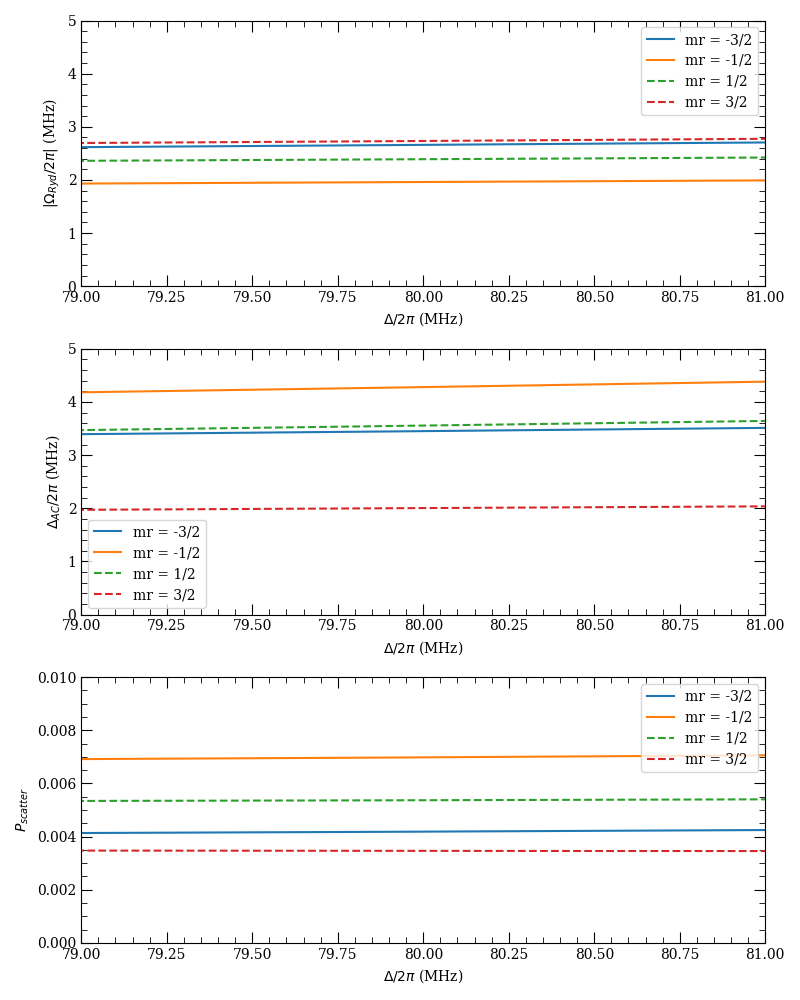

In [30]:
fig, axar = plt.subplots(3,1,figsize = (8,10))
ln = ['-','-','--','--']

xlim = [79,81]

for i, mr in enumerate(np.arange(-3/2,3/2+1)):
    plt_det = detuning * 1e-6 / (2 * pi)
    #rabi_r = rabi.real
    axar[0].plot(plt_det, np.abs(rabi[i,:])*1e-6/(2*pi), label = f"mr = {mr*2:.0f}/2",linestyle=ln[i])
    axar[0].set_ylim(0,5)
    axar[0].set_xlim(*xlim)
    axar[0].set_ylabel("$|\Omega_{Ryd}/2\pi|$ (MHz)")
    axar[0].set_xlabel("$\Delta/2\pi$ (MHz)")
    axar[0].legend()
    
    axar[1].plot(plt_det, AC_stark[i,:].real*1e-6/(2*pi), label = f"mr = {mr*2:.0f}/2",linestyle=ln[i])
    axar[1].set_ylim(0,5)
    axar[1].set_xlim(*xlim)
    axar[1].set_ylabel("$\Delta_{AC}/2\pi$ (MHz)")
    axar[1].set_xlabel("$\Delta/2\pi$ (MHz)")
    axar[1].legend()
    
    axar[2].plot(plt_det, abs(p_scatter[i,:]), label = f"mr = {mr*2:.0f}/2",linestyle=ln[i])
    axar[2].set_ylim(0,0.010)
    axar[2].set_xlim(*xlim)
    axar[2].set_ylabel("$P_{scatter}$")
    axar[2].set_xlabel("$\Delta/2\pi$ (MHz)")
    axar[2].legend()
#    ax.set_title(f"mr = {mr*2:.0f}/2")

fig.tight_layout()
fig.show()
fig.savefig("RabiEstimatesZoom.png")

In [34]:
lim_det = np.where((2*pi*xlim[0]*1e6 < detuning)*(detuning < 2*pi*1e6*xlim[1]))[0]
AC_starkP = AC_stark[:,lim_det]
P_scatP = p_scatter[:,lim_det]
rabiP = rabi[:,lim_det]

no_stark_ind = np.where(np.abs(AC_starkP[2]) == min(np.abs(AC_starkP[2])))
min_p_ind = np.where(P_scatP[3] == min(P_scatP[3]))
opt_ind = min_p_ind
# opt_ind = no_stark_ind
print(f"detuning that provides minimal scattering probability = 2 pi x {detuning[lim_det][opt_ind][0]*1e-6/(2*pi):.2f}MHz")
for i,mr in enumerate(np.arange(-3/2,5/2)):
    print(f"mr = {int(2*mr)}/2")
    print(f"\trabi frequency : 2 pi x {abs(rabiP[i][opt_ind][0]/(2*pi)*1e-6):.2f}MHz")
    print(f"\tAC stark shift : 2 pi x {abs(AC_starkP[i][opt_ind][0]/(2*pi)*1e-6):.2f}MHz")
    print(f"\tScattering probability : {abs(P_scatP[i][opt_ind][0]):.5f}")

detuning that provides minimal scattering probability = 2 pi x 80.47MHz
mr = -3/2
	rabi frequency : 2 pi x 2.68MHz
	AC stark shift : 2 pi x 3.48MHz
	Scattering probability : 0.00421
mr = -1/2
	rabi frequency : 2 pi x 1.98MHz
	AC stark shift : 2 pi x 4.33MHz
	Scattering probability : 0.00702
mr = 1/2
	rabi frequency : 2 pi x 2.40MHz
	AC stark shift : 2 pi x 3.60MHz
	Scattering probability : 0.00538
mr = 3/2
	rabi frequency : 2 pi x 2.75MHz
	AC stark shift : 2 pi x 2.02MHz
	Scattering probability : 0.00346


In [32]:
lim_det = np.where((2*pi*xlim[0]*1e6 < detuning)*(detuning < 2*pi*1e6*xlim[1]))[0]
AC_starkP = AC_stark[:,lim_det]
P_scatP = p_scatter[:,lim_det]
rabiP = rabi[:,lim_det]


## Other swept Parameters

In [43]:
p_ge = 88e-3  # W
p_er = 51e-3 # 52e-3  # W
w_ge = 15e-6  # m
w_er = 5e-6  # m
angles = np.linspace(0,2*pi,300)
pol_ge = (lambda theta: SphericalVector([0,np.sin(theta),np.cos(theta)]))(3.9)  # Z-Y polarized, angle theta from Z
pol_er = lambda theta: SphericalVector([0,np.sin(theta),np.cos(theta)]) # Z-Y polarized, angle theta from Z
k_ar = SphericalVector([1,0,0], spherical_basis=False)  # X polarized
nr = 60  # Target Rydberg State
phi_ge = 0  # phase on 684nm field
phi_er = 0  # phase of 595nm field

bias_B = 5.8 * gauss # bias field in the z-direction

# Possible laser detunings from unperturbed intermediate states
detuning = 2*pi*80e6 #  np.linspace(min(DHF[1:]) - 0.501e9, max(DHF[1:]) + 0.5e9, 1000)
#detuning = np.linspace(2*pi*1e7, 2*pi*1e8, 1000)
swept_param = angles
delta = np.array([detuning - DET for DET in DHF])

In [44]:
O_ge = np.zeros((7,15,len(swept_param)), dtype=complex)  # ground-to-excited rabi frequencies
O_er = np.zeros((7,15,4,len(swept_param)), dtype=complex)  # excited-to-rydberg rabi frequencies

z_g = zeeman_g(bias_B)
z_e = np.zeros((7,15), dtype=float)  # zeeman shift on each of the states in the excited manifold
z_r = np.zeros(4, dtype=float)  # zeeman shift on each of the states in the Rydberg manifold

for fp in range(1,7):
    for mp in range(-fp, fp+1):
        O_ge[fp,mp,:] = q_rabi_frequency(p_ge, w_ge, pol_ge, k_ar, q_rad_int, fp, mp, phi = phi_ge)
        z_e[fp,mp] = zeeman_e(bias_B, fp, mp)
        for i, mr in enumerate(np.arange(-3/2,3/2+1,1)):
            O_er[fp,mp,i,:] = np.array([d_rabi_frequency(p_er, w_er, pol_er(th), nr, fp, mp, mr, phi = phi_er) for th in angles])
            z_r[i] = zeeman_R(bias_B, nr, mr)


In [45]:
rabi = np.zeros((4, len(swept_param)), dtype = complex)
AC_stark = np.zeros((4, len(swept_param)), dtype = complex)
p_scatter = np.zeros((4, len(swept_param)), dtype = complex)

for i, mr in enumerate(np.arange(-3/2,3/2+1,1)):
    for fp in range(1,7):
        for mp in range(-fp, fp+1):
            d = delta[fp]-z_e[fp,mp]
            rabi[i] += (O_ge[fp,mp]*O_er[fp,mp,i])/(2 * d)
            AC_stark[i] += (O_ge[fp,mp]*O_ge[fp,mp].conjugate() - O_er[fp,mp,i]*O_er[fp,mp,i].conjugate())/(4 * d)
            p_scatter[i] += gamma_e * (O_ge[fp,mp]*O_ge[fp,mp].conjugate() + O_er[fp,mp,i]*O_er[fp,mp,i].conjugate())/(2 * d)**2
    t_pi = pi/np.absolute(rabi[i])
    p_scatter[i] *= t_pi

<IPython.core.display.Javascript object>


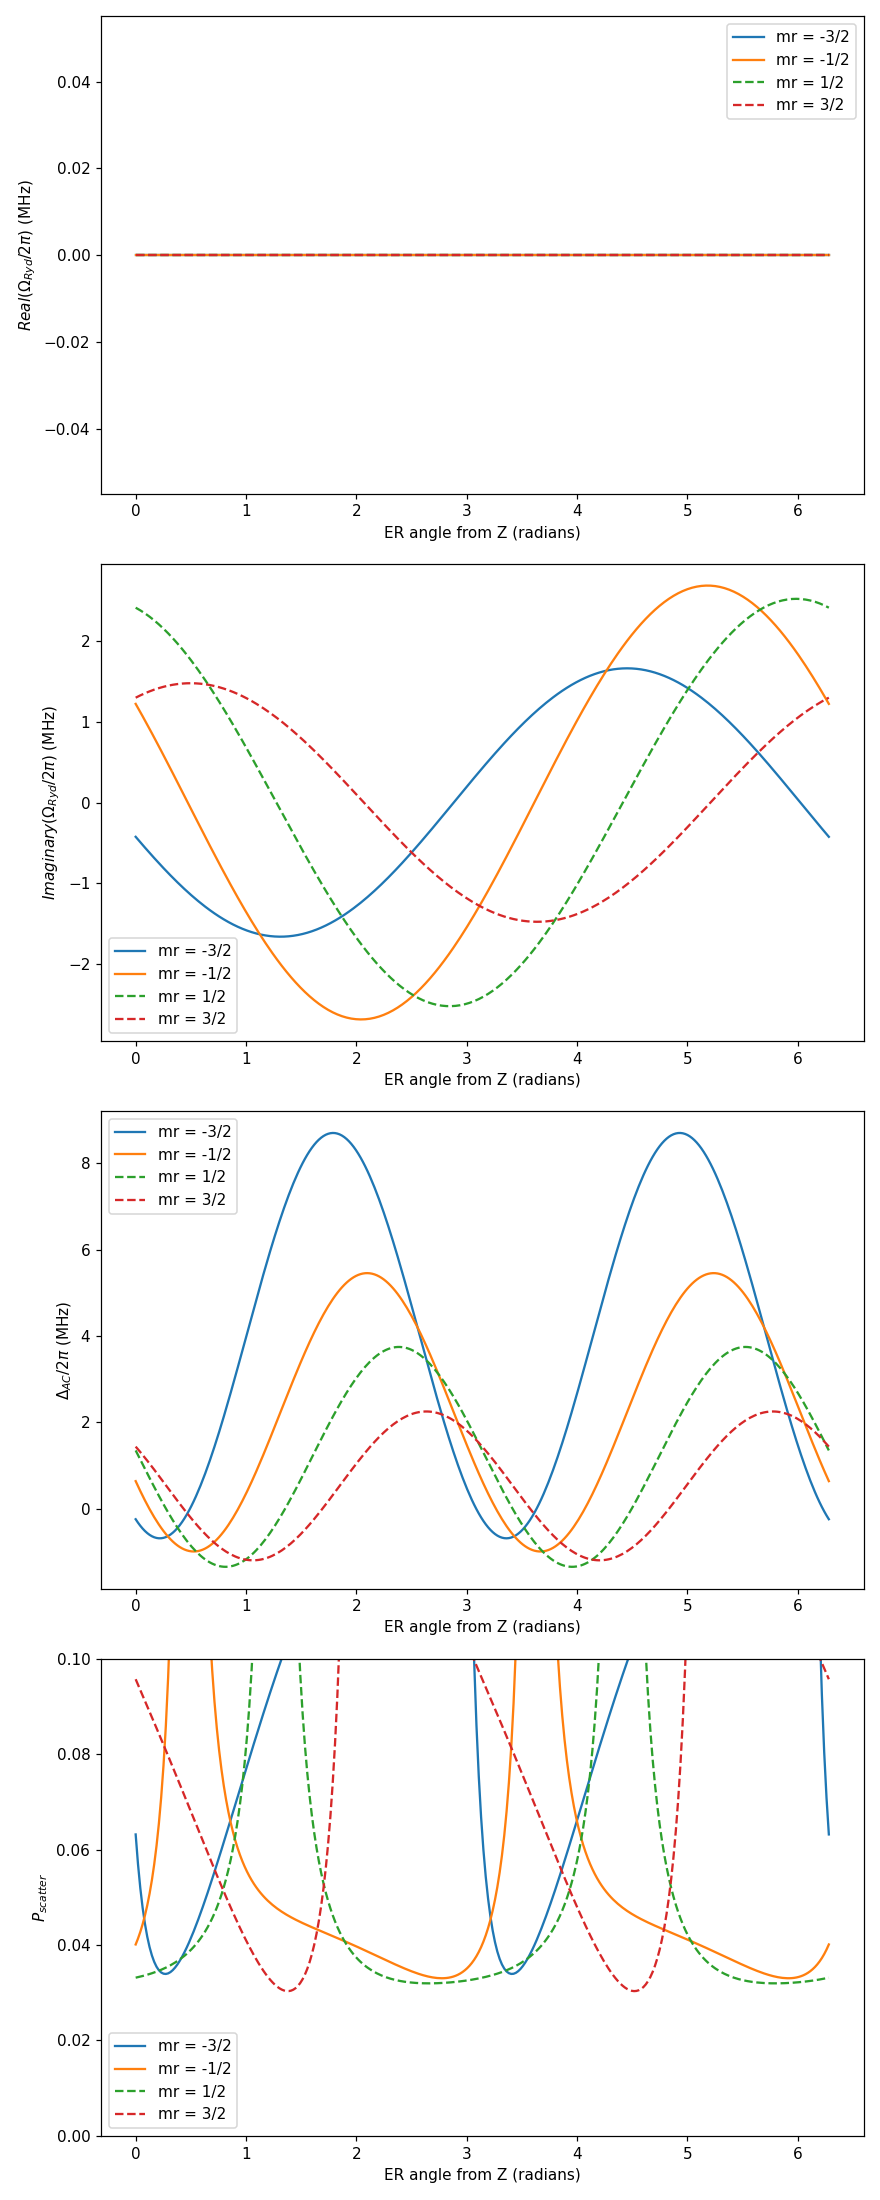

In [46]:
fig, axar = plt.subplots(4,1,figsize = (8,20))
ln = ['-','-','--','--']
for i, mr in enumerate(np.arange(-3/2,3/2+1)):
    plt_det = detuning * 1e-6 / (2 * pi)
    xlab = "ER angle from Z (radians)"
    #rabi_r = rabi.real
    axar[0].plot(swept_param, rabi[i,:].real*1e-6/(2*pi), label = f"mr = {mr*2:.0f}/2",linestyle=ln[i])
    # axar[0].set_ylim(-3,3)
    axar[0].set_ylabel("$Real(\Omega_{Ryd}/2\pi)$ (MHz)")
    axar[0].set_xlabel(xlab)
    axar[0].legend()
    
    axar[1].plot(swept_param, rabi[i,:].imag*1e-6/(2*pi), label = f"mr = {mr*2:.0f}/2",linestyle=ln[i])
    #axar[1].set_ylim(-1.75,1.75)
    axar[1].set_ylabel("$Imaginary(\Omega_{Ryd}/2\pi)$ (MHz)")
    axar[1].set_xlabel(xlab)
    axar[1].legend()
    
    axar[2].plot(swept_param, AC_stark[i,:].real*1e-6/(2*pi), label = f"mr = {mr*2:.0f}/2",linestyle=ln[i])
    #axar[2].set_ylim(0,5)
    axar[2].set_ylabel("$\Delta_{AC}/2\pi$ (MHz)")
    axar[2].set_xlabel(xlab)
    axar[2].legend()
    
    axar[3].plot(swept_param, abs(p_scatter[i,:]), label = f"mr = {mr*2:.0f}/2",linestyle=ln[i])
    axar[3].set_ylim(0,0.1)
    axar[3].set_ylabel("$P_{scatter}$")
    axar[3].set_xlabel(xlab)
    axar[3].legend()
#    ax.set_title(f"mr = {mr*2:.0f}/2")

fig.tight_layout()
fig.show()
fig.savefig("RabiEstimates.png")

# Haphazard LaTeX on the General Zeeman Matrix Elements

## Computing the Matrix element between FS states
Given a magnetic field $\vec{B}$, the perturbing Hamiltonian is:
$$H_B = \frac{\mu_b}{\hbar} \textbf{B} \cdot (g_s \hat{\textbf{S}} + g_l \hat{\textbf{L}})$$

Choosing states $|\alpha, l, j, m_j>$ and $|\alpha, l, j', m_j'>$
We can write the matrix element as
$$<\alpha, l, j', m_j'| H_B |\alpha, l, j, m_j>  = \frac{\mu_b}{\hbar} \sum_{q = -1}^1 (-1)^q B_q <\alpha, l, j', m_j'| g_s \hat{S}_{-q} + g_l \hat{L}_{-q} |\alpha, l, j, m_j>  $$

We can then expand our FS states into separated spin and orbit states:
$$|\alpha, l, j, m_j> = \sum_{m_l,m_s} |\alpha, l, 1/2; m_l, m_s> <\alpha, l, 1/2; m_l, m_s |\alpha, l, j, m_j> $$
$$|\alpha, l, j, m_j> = \sum_{m_l,m_s} |\alpha, l, 1/2; m_l, m_s> C_{l,m_l,1/2,m_s}^{j,m_j} $$

We can then rewrite our sum as
$$<\alpha, l, j', m_j'| H_B |\alpha, l, j, m_j>  = \frac{\mu_b}{\hbar} \sum_{q = -1}^1 (-1)^q B_q \sum_{m_l,m_l',m_s,m_s'} C_{l,ml',1/2,ms'}^{j',m_j'} C_{l,ml,1/2,ms}^{j,m_j} \left(\delta_{m_l,m_l'} g_s <1/2,m_s'|\hat{S}_{-q}|1/2,m_s> + \delta_{m_s,m_s'} g_l <l,ml'|\hat{L}_{-q}|l,ml>\right)$$

We can rewrite those matrix elements using the Wigner-Eckart theorem.
$$ <1/2,m_s'|\hat{S}_{-q}|1/2,m_s> = \frac{<1/2||\hat{S}||1/2>}{\sqrt{2 \frac{1}{2}+1}}C_{1,-q,1/2,m_s}^{1/2,m_s'} $$

We can find the general form of a reduced matrix element of an angular momentum operator (given the total angular momentum quantum numbers are the same) by computing
$$ <j,j|\hat{J}_0|j,j> = \hbar j = \frac{<j||\hat{J}||j>}{\sqrt{2j+1}}C_{1,0,j,j}^{j,j} $$
where $C_{1,0,j,j}^{j,j} = \sqrt{\frac{j}{j+1}}$
thus
$$ <j||\hat{J}||j> = \hbar\sqrt{j(j+1)(2j+1)} $$

We can use the above to rewrite the whole matrix element as
$$<\alpha, l, j', m_j'| H_B |\alpha, l, j, m_j>  = \mu_b \sum_{q = -1}^1 (-1)^q B_q \sum_{m_l,m_l',m_s,m_s'} C_{l,ml',1/2,ms'}^{j',m_j'} C_{l,ml,1/2,ms}^{j,m_j}\left(\delta_{ml,ml'}g_s \frac{\sqrt{3}}{2}C_{1,-q,1/2,ms}^{1/2,ms'} + \delta_{ms,ms'} g_l \sqrt{l (l+1)} C_{1, -q, l, ml}^{l,m_l'}\right)$$

In the code we switch the $q$ and $-q$ above to save space in the long clebsch gordan coefficients. 

## Computing the matrix elements between HF states
Considering the nuclear interaction our hamiltonian is
$$H_B = \frac{\mu_b}{\hbar} \textbf{B} \cdot (g_s \hat{\textbf{S}} + g_l \hat{\textbf{L}} + g_I \hat{\textbf{I}})$$

Choosing states $|\alpha, l, j, f, m_f>$ and $|\alpha, l, j', f', m_f'>$
We can write the matrix element as
$$<\alpha, l, j', f', m_f'| H_B |\alpha, l, j, f, m_f>  = \frac{\mu_b}{\hbar} \sum_{q = -1}^1 (-1)^q B_q <\alpha, l, j', f', m_f'| g_s \hat{S}_{-q} + g_l \hat{L}_{-q} + g_I \hat{I}_{-q}|\alpha, l, j, f, m_f>  $$

And similarly begin decomposing it into the hyperfine basis to arrive at  
$<\alpha, l, j', f', m_f'| H_B |\alpha, l, j, f, m_f>$
$$ = \frac{\mu_b}{\hbar} \sum_{q = -1}^1 (-1)^q B_q \sum_{m_j,m_j',m_I,m_I'}C_{j',m_j',I,m_I'}^{f',m_f'}C_{j,m_j,I,m_I}^{f,m_f} \left(\hbar \delta_{m_j,m_j'} g_I \sqrt{I(I+1)}C_{1,-q,I,m_I}^{I,m_I'} + \delta_{m_I,m_I'} <\alpha, l, j', m_j'|g_s\hat{S}_{-q} + g_l \hat{L}_{-q}||\alpha, l, j, m_j>\right) $$
  
In this implementation as above we flip $q$ and $-q$ for convenience
  
In the code, that lower matrix element is equivalent to the FS matrix element when $\textbf{B} = (-1)^q\textbf{e}_{q}\frac{\hbar}{\mu_b}$. So we compute it with the following line:  
- **(-1)\*\*q * zeeman_fs(1, SphericalVector(qar), lo, j, mj, jp, mjp)/mub**  
    - where **qar** is a length 3 list where all entries are 0, except index **-q**
    - The $\hbar$ is missing because we've canceled it with the leading $\frac{1}{\hbar}$

In [ ]:
%matplotlib notebook

import numpy as np
from matplotlib import pyplot as plt
from scipy import pi
from sympy.physics.wigner import clebsch_gordan,wigner_3j,wigner_6j
from sympy import N

In [ ]:
from basics import *
from rabi_frequencies import *
from atomic_physics import *

In [ ]:
F = 4
Fp = 3
B = 1 * gauss
mfs = np.arange(-F,F+1,1)
mfps = np.arange(-Fp,Fp+1,1)
zeeman = np.zeros((len(mfs),len(mfs)),dtype=float)
for mf in mfs:
    for mfp in mfps:
        zeeman[mf,mfp] = zeeman_me_hf(B,SphericalVector([1,0,0]),0,1/2,F,mf,1/2,Fp,mfp)

In [ ]:
print("\n".join([
    ",  ".join([f"{zeeman[mf,mfp]*1e-6/h:.2f}" for mf in mfs])
for mfp in mfps]))

<IPython.core.display.Javascript object>


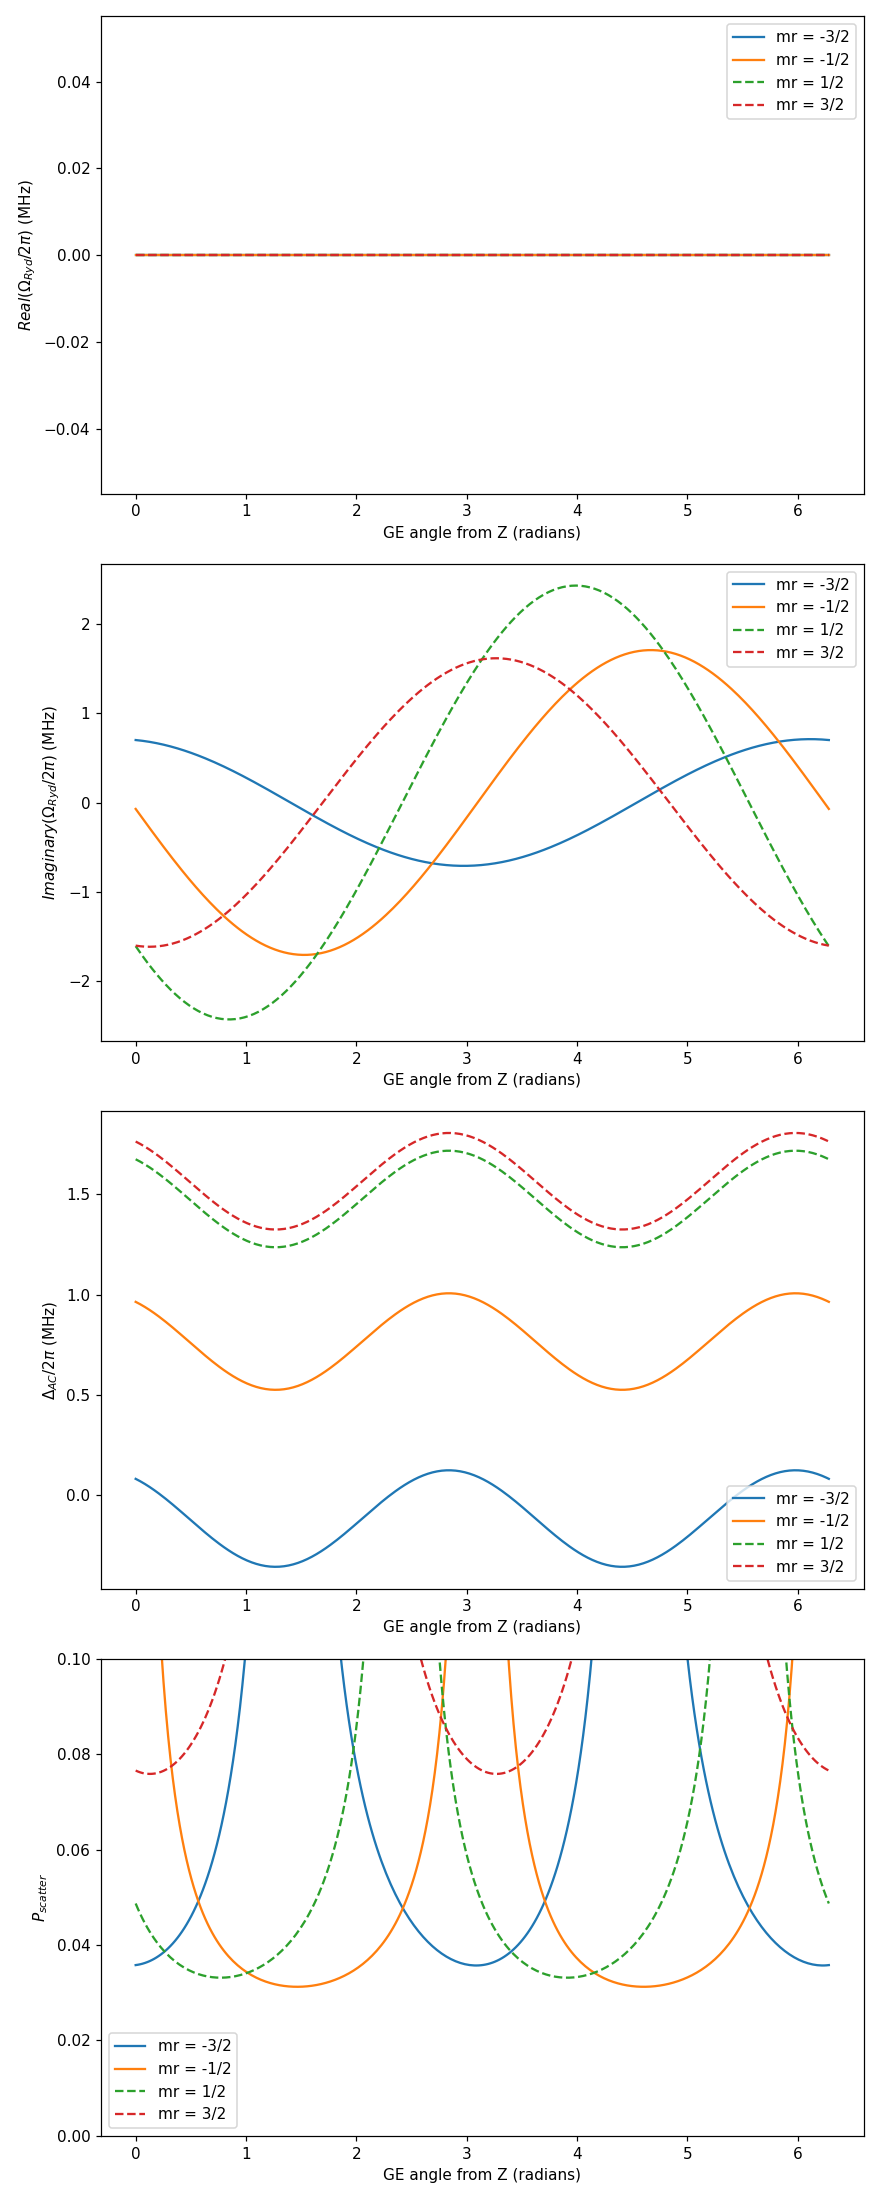

In [34]:
fig, axar = plt.subplots(4,1,figsize = (8,20))
ln = ['-','-','--','--']
for i, mr in enumerate(np.arange(-3/2,3/2+1)):
    plt_det = detuning * 1e-6 / (2 * pi)
    xlab = "GE angle from Z (radians)"
    #rabi_r = rabi.real
    axar[0].plot(swept_param, rabi[i,:].real*1e-6/(2*pi), label = f"mr = {mr*2:.0f}/2",linestyle=ln[i])
    # axar[0].set_ylim(-3,3)
    axar[0].set_ylabel("$Real(\Omega_{Ryd}/2\pi)$ (MHz)")
    axar[0].set_xlabel(xlab)
    axar[0].legend()
    
    axar[1].plot(swept_param, rabi[i,:].imag*1e-6/(2*pi), label = f"mr = {mr*2:.0f}/2",linestyle=ln[i])
    #axar[1].set_ylim(-1.75,1.75)
    axar[1].set_ylabel("$Imaginary(\Omega_{Ryd}/2\pi)$ (MHz)")
    axar[1].set_xlabel(xlab)
    axar[1].legend()
    
    axar[2].plot(swept_param, AC_stark[i,:].real*1e-6/(2*pi), label = f"mr = {mr*2:.0f}/2",linestyle=ln[i])
    #axar[2].set_ylim(0,5)
    axar[2].set_ylabel("$\Delta_{AC}/2\pi$ (MHz)")
    axar[2].set_xlabel(xlab)
    axar[2].legend()
    
    axar[3].plot(swept_param, abs(p_scatter[i,:]), label = f"mr = {mr*2:.0f}/2",linestyle=ln[i])
    axar[3].set_ylim(0,0.1)
    axar[3].set_ylabel("$P_{scatter}$")
    axar[3].set_xlabel(xlab)
    axar[3].legend()
#    ax.set_title(f"mr = {mr*2:.0f}/2")

fig.tight_layout()
fig.show()
fig.savefig("RabiEstimates.png")